# Strip Templates and Manually Label Additional Comments
This notebook:
1. reads in the dataset of ~150k comments
2. merges the labels from the dataset of 500 comments manually labelled by CWP
3. labels ~50k additional comments based on identified templates
4. exports a random sample of 1000 unlabelled comments
5. imports the resulting file after these comments have been manually labelled
6. merges the new labels to the dataset
7. exports the resulting dataset to data/comments-labelled.csv

In [1]:
import pandas as pd

In [2]:
comments = pd.read_csv('data/comments.csv')
cwp = pd.read_csv('data/cwp-sample.csv')

In [3]:
# merge the 'Sentiment' labels from cwp dataset
cwp['labelled_by'] = 'hand' # obs will be labelled by hand or by template
df = pd.merge(
    comments, 
    cwp[['ID', 'Sentiment', 'labelled_by']], 
    how='left', 
    left_on='document_id', 
    right_on='ID'
)

In [4]:
# Remove comments with attachments
with_attachment_count = len(df[df['has_attachments']==True])
print("Removed " + str(with_attachment_count) + " comments with attachments.")
df = df[df['has_attachments']==False]

Removed 3814 comments with attachments.


In [5]:
empty_comments = ['Please Write Your Comment Here:', 'See attached']
for text in empty_comments:
    print('Removed %s comments consisting only of only "%s"' % (str(len(df[df['comment']==text])), text))
    df = df[df['comment']!=text]

Removed 1399 comments consisting only of only "Please Write Your Comment Here:"
Removed 55 comments consisting only of only "See attached"


In [7]:
# read in list of high frequency sentences. 
# Count the number of periods as a proxy for the number of sentences
# Tally the sentiment associated with the HFSs that occur in each comment
hfs = pd.read_csv('data/high-frequency-sentences.csv')
df['pos'] = 0
df['neg'] = 0
for i, item in hfs.iterrows():
    if item['sentiment'] == 'Positive':
        df.loc[df['comment'].str.contains(item['sentence']), 'pos'] += 1
    elif item['sentiment'] == 'Negative':
        df.loc[df['comment'].str.contains(item['sentence']), 'neg'] += 1

/Users/markegge/anaconda3/envs/comments/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()
/Users/markegge/anaconda3/envs/comments/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


In [ ]:
# import csv
# with open('data/comment-templates.csv', 'r') as f:
#     reader = csv.DictReader(f)
#     templates = [row for row in reader]
# templates[:2]
# df['template'] = False
# for template in templates:
#     count = len(df[~df['template'] & df['comment'].str.contains(template['Key']) ] )
#     print('Labelled %s comments as %s with string "%s"' % (str(count), template['Sentiment'], template['Key']))
#     df.loc[~df['template'] & df['comment'].str.contains(template['Key']), ['Sentiment', 'template']] = [template['Sentiment'], True]


In [ ]:
# print('Drawing a random sample of 1000 from a population of %s unlabelled comments.' % str(len(df['Sentiment'].isnull())))
# print('having first removed ' + str(len(df[df['Sentiment'] == 'Positive'])) + ' positive comments')
# print('and having first removed ' + str(len(df[df['Sentiment'] == 'Negative'])) + ' negative comments')

# sample = df[df['Sentiment'].isnull()].sample(n=1000)
# sample.to_csv('data/expanded_sample.csv')

(Manually labelled comments by reviewing in Excel and saved resulting file as expanded_sample-labelled.csv)

In [10]:
# bring in the results from my manual labelling
labels = pd.read_csv('data/expanded_sample-labelled.csv')
for sentiment in list(labels['Sentiment'].unique()):
    doc_ids = labels.loc[labels['Sentiment']==sentiment, 'document_id']
    df.loc[df['document_id'].isin(doc_ids), ['Sentiment', 'labelled_by']] = [sentiment, 'hand']    
    print("Labelled %s %s" % (str(len(doc_ids)), sentiment))

Labelled 941 Positive
Labelled 41 Negative
Labelled 18 Neutral


In [11]:
df.loc[df['pos'] >= 1, ['Sentiment', 'labelled_by']] = ['Positive', 'template']
df.loc[df['neg'] >= 1, ['Sentiment', 'labelled_by']] = ['Negative', 'template']

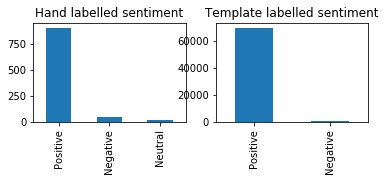

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(221)
plt.title('Hand labelled sentiment')
df.loc[df['labelled_by']=='hand', 'Sentiment'].value_counts().plot.bar()
plt.subplot(222)
plt.title('Template labelled sentiment')
df.loc[df['labelled_by']=='template', 'Sentiment'].value_counts().plot.bar()

plt.show()

In [18]:
# write results to file
df.to_csv('data/comments-labelled.csv')